## Нейросети - сверточные сети.
### Ноутбук составлен по воспоминаниям из разных курсов, в первую очередь Stanford cs231n, Jeremy Howard Fast AI, а также по материалам сайта https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/

In [1]:
import numpy as np
import math
import random

In [2]:
def pad_with_zeros(X):
    if len(X.shape) == 2:
        X_pad = np.zeros((X.shape[0] + 2, X.shape[1] + 2))
        X_pad[1:-1,1:-1] = X
        return X_pad
    elif len(X.shape) == 3:
        result = []
        for img in X:
            img_pad = np.zeros((img.shape[0] + 2, img.shape[1] + 2))
            img_pad[1:-1,1:-1] = img
            result.append(img_pad)
        return np.array(result)
    else:
        print("Only (H x W) and (Batch x H x W) shapes are supported")
        return None

In [3]:
pict = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])

In [4]:
pad_with_zeros(pict)

array([[0., 0., 0., 0., 0.],
       [0., 1., 2., 3., 0.],
       [0., 4., 5., 6., 0.],
       [0., 7., 8., 9., 0.],
       [0., 0., 0., 0., 0.]])

In [5]:
batch = []
for i in range(8):
    batch.append(pict)
batch_padded = pad_with_zeros(np.array(batch))

In [6]:
batch_padded.shape

(8, 5, 5)

In [7]:
batch_padded[0]

array([[0., 0., 0., 0., 0.],
       [0., 1., 2., 3., 0.],
       [0., 4., 5., 6., 0.],
       [0., 7., 8., 9., 0.],
       [0., 0., 0., 0., 0.]])

In [8]:
X = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])

In [9]:
K = np.array([[0.0, 1.0], [2.0, 3.0]])

In [10]:
def conv2d(X, K, pad = False):
    if pad:
        X = pad_with_zeros(X)
        
    h, w = X.shape[0], X.shape[1]
    k1, k2 = K.shape[0], K.shape[1]
    result = np.zeros((h - k1 + 1, w - k2 + 1))
    
    for i in range(0 + k1 - 1, result.shape[0] + k1 - 1):
        for j in range(0 + k2 - 1, result.shape[1] + k2 - 1):
            result[i - k1 + 1, j - k2 + 1] = (X[i - k1 + 1: i + 1, j - k2 + 1: j + 1] * K).sum()
    return result

In [11]:
conv2d(X, K)

array([[25., 31.],
       [43., 49.]])

In [12]:
conv2d(X, K, pad = True)

array([[ 3.,  8., 13.,  6.],
       [13., 25., 31., 12.],
       [25., 43., 49., 18.],
       [ 7.,  8.,  9.,  0.]])

Попробуем сначала простой слой с одним фильтром - 1 канал на входе, 1 на выходе

In [13]:
def rot180(X):
    return np.rot90(np.rot90(X))

In [14]:
class ConvLayer:
    
    def __init__(self, kernel_size = 3, pad = False):
        # self.kernel = np.random.default_rng().uniform(-1, 1, (kernel_size, kernel_size)).astype(np.float32)
        n = kernel_size**2
        self.kernel = np.random.normal(0, math.sqrt(2. / n), (kernel_size, kernel_size)).astype(np.float32)
        self.pad = pad
        self.X_ = None
        
    def forward(self, X):
        if len(X.shape) == 2:
            if self.pad: 
                X = pad_with_zeros(X)
            self.X_ = X
            return conv2d(X, self.kernel)
        
        elif len(X.shape) == 3:
            if self.pad: 
                X = pad_with_zeros(X)
            self.X_ = X
            result = []
            for img in X:
                result.append(conv2d(img, self.kernel))
            return np.array(result)
                    
        else:
            print("Only (H x W) and (Batch x H x W) shapes are supported")
            return None
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        if len(upstr_grad.shape) == 2:
            # расчет градиентов по весам фильтра
            grad_w = conv2d(self.X_, rot180(upstr_grad))
            if debug == 1: print(f'Conv: grad_w.shape = {grad_w.shape}, upstr_grad.shape = {upstr_grad.shape}')
            if debug > 1: print(f'Conv: grad_w = {grad_w}')

            # расчет градиентов по входам
            for i in range(self.X_.shape[0] - self.kernel.shape[0] - self.pad):
                upstr_grad = pad_with_zeros(upstr_grad)
            grad_x = conv2d(upstr_grad, rot180(self.kernel))
            if debug == 1: print(f'Conv: grad_x.shape = {grad_x.shape}, upstr_grad.shape = {upstr_grad.shape}')
            if debug > 1: print(f'Conv: grad_x = {grad_x}')

            self.kernel += -1 * grad_w * lr # домножаем на -1, так как градиентный шаг выполняется в направлении антиградиента
            return grad_x
        
        elif len(upstr_grad.shape) == 3:
            # расчет градиентов по весам фильтра
            grad_w_batch = []
            for i in range(upstr_grad.shape[0]):
                grad_w = conv2d(self.X_[i], rot180(upstr_grad[i]))
                grad_w_batch.append(grad_w)
            grad_w_batch = np.array(grad_w_batch)
            
            if debug == 1: print(f'Conv: grad_w_batch.shape = {grad_w_batch.shape}, upstr_grad.shape = {upstr_grad.shape}')
            if debug > 1: print(f'Conv: grad_w_batch = {grad_w_batch}')
            
             # расчет градиентов по входам
            grad_x_batch = []
            for i in range(upstr_grad.shape[0]):
                ug = upstr_grad[i]
                # for j in range(self.X_.shape[-1] - self.kernel.shape[0] - self.pad):
                for j in range(2 - self.pad):    
                    ug = pad_with_zeros(ug)
                grad_x = conv2d(ug, rot180(self.kernel))
                grad_x_batch.append(grad_x)
            grad_x_batch = np.array(grad_x_batch)
            if debug == 1: print(f'Conv: grad_x_batch.shape = {grad_x_batch.shape}, upstr_grad.shape = {upstr_grad.shape}')
            if debug > 1: print(f'Conv: grad_x_batch = {grad_x_batch}')
            return grad_x_batch
            
            self.kernel += -1 * grad_w_batch.mean(axis = 0) * lr # домножаем на -1, так как градиентный шаг выполняется в направлении антиградиента
        
        else:
            print("Only (H x W) and (Batch x H x W) shapes are supported")
            return None

In [15]:
CL = ConvLayer(kernel_size = 2)

In [16]:
CL.forward(X)

array([[1.93439382, 2.28600389],
       [2.98922402, 3.34083408]])

In [17]:
upstr_grad = np.array([[0, 1], [2, 1]])

In [18]:
CL.backward(upstr_grad, debug = 1)

Conv: grad_w.shape = (2, 2), upstr_grad.shape = (2, 2)
Conv: grad_x.shape = (3, 3), upstr_grad.shape = (4, 4)


array([[ 0.        ,  0.5097881 , -0.54877162],
       [ 1.01957619, -1.15693617,  0.41100299],
       [-1.13836205,  1.3503682 ,  0.95977461]])

In [19]:
X_batch = []
for i in range(5):
    X_batch.append(X)
X_batch = np.array(X_batch)
X_batch.shape

(5, 3, 3)

In [20]:
fwres = CL.forward(X_batch)
fwres

array([[[-0.50560609, -0.833996  ],
        [-1.49077582, -1.81916574]],

       [[-0.50560609, -0.833996  ],
        [-1.49077582, -1.81916574]],

       [[-0.50560609, -0.833996  ],
        [-1.49077582, -1.81916574]],

       [[-0.50560609, -0.833996  ],
        [-1.49077582, -1.81916574]],

       [[-0.50560609, -0.833996  ],
        [-1.49077582, -1.81916574]]])

In [21]:
upstr_grad = np.array([[[1, 1], [1, 1]],
                       [[1, 1], [1, 1]],
                       [[1, 1], [1, 1]],
                       [[1, 1], [1, 1]],
                       [[1, 1], [1, 1]]])

In [22]:
CL.backward(upstr_grad, debug = 1)

Conv: grad_w_batch.shape = (5, 2, 2), upstr_grad.shape = (5, 2, 2)
Conv: grad_x_batch.shape = (5, 5, 5), upstr_grad.shape = (5, 2, 2)


array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.41978809, -0.25898352, -0.67877162,
          0.        ],
        [ 0.        , -0.35939291, -0.32838991,  0.031003  ,
          0.        ],
        [ 0.        , -0.779181  , -0.06940639,  0.70977461,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.41978809, -0.25898352, -0.67877162,
          0.        ],
        [ 0.        , -0.35939291, -0.32838991,  0.031003  ,
          0.        ],
        [ 0.        , -0.779181  , -0.06940639,  0.70977461,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.41978809, -0.25898352, -0.67877162,
          0

Без padding ответ верный, попробуем с padding

In [23]:
CL = ConvLayer(kernel_size = 3, pad = True)

In [24]:
CL.forward(X)

array([[ 6.17379129,  9.5907094 ,  5.8195812 ],
       [12.59077797, 16.8328417 ,  9.84418827],
       [ 9.88019411, 11.62135098,  4.40498304]])

In [25]:
upstr_grad = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 0]])

In [26]:
CL.backward(upstr_grad, debug = 1)

Conv: grad_w.shape = (3, 3), upstr_grad.shape = (3, 3)
Conv: grad_x.shape = (3, 3), upstr_grad.shape = (5, 5)


array([[0.34613728, 0.7333007 , 1.4888612 ],
       [1.21522311, 2.53445921, 4.0209797 ],
       [1.8468791 , 5.46674696, 5.22698009]])

In [27]:
CL.forward(X_batch)

array([[[-1.58620873, -2.75929062, -3.16041881],
        [-3.6392221 , -6.70715834, -6.16581173],
        [-1.65980604, -3.86864913, -5.11501692]],

       [[-1.58620873, -2.75929062, -3.16041881],
        [-3.6392221 , -6.70715834, -6.16581173],
        [-1.65980604, -3.86864913, -5.11501692]],

       [[-1.58620873, -2.75929062, -3.16041881],
        [-3.6392221 , -6.70715834, -6.16581173],
        [-1.65980604, -3.86864913, -5.11501692]],

       [[-1.58620873, -2.75929062, -3.16041881],
        [-3.6392221 , -6.70715834, -6.16581173],
        [-1.65980604, -3.86864913, -5.11501692]],

       [[-1.58620873, -2.75929062, -3.16041881],
        [-3.6392221 , -6.70715834, -6.16581173],
        [-1.65980604, -3.86864913, -5.11501692]]])

In [28]:
upstr_grad = np.array([[[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]]])

In [29]:
CL.backward(upstr_grad, debug = 1)

Conv: grad_w_batch.shape = (5, 3, 3), upstr_grad.shape = (5, 3, 3)
Conv: grad_x_batch.shape = (5, 3, 3), upstr_grad.shape = (5, 3, 3)


array([[[-0.62815259, -0.71435668, -0.51274082],
        [-0.97015417, -1.32172805, -0.97735064],
        [-0.85790731, -0.74479721, -0.30548938]],

       [[-0.62815259, -0.71435668, -0.51274082],
        [-0.97015417, -1.32172805, -0.97735064],
        [-0.85790731, -0.74479721, -0.30548938]],

       [[-0.62815259, -0.71435668, -0.51274082],
        [-0.97015417, -1.32172805, -0.97735064],
        [-0.85790731, -0.74479721, -0.30548938]],

       [[-0.62815259, -0.71435668, -0.51274082],
        [-0.97015417, -1.32172805, -0.97735064],
        [-0.85790731, -0.74479721, -0.30548938]],

       [[-0.62815259, -0.71435668, -0.51274082],
        [-0.97015417, -1.32172805, -0.97735064],
        [-0.85790731, -0.74479721, -0.30548938]]])

С padding тоже верно

Попробуем построить сверточную нейросеть с одним фильтром для работы с MNIST. Возьмем реализации требуемых классов из предыдущего ноутбука

In [30]:
# class Network:
#     """Реализация нейросети с методом predict, чтобы экземпляры класса можно было использовать в plot_decision_regions.
    
    
#     Параметры инициализатора:
#     layers -- список экземпляров классов слоев нейросети
    
#     Параметры forward():
#     X -- матрица размерности (N, D), где N - размер batch, D - количество признаков экземпляра выборки
    
#     Парметры backward():
#     upstr_grad -- входящие градиенты со следующего уровня
#     lr -- learning rate
#     debug -- уровень логгирования.
#     """
    
#     def __init__(self, layers):
#         self.layers = layers
        
#     def forward(self, X):
#         for layer in self.layers:
#             X = layer.forward(X)
#         return X
    
#     def backward(self, upstr_grad, lr = 0.01, debug = 0):
#         for layer in reversed(self.layers):
#             upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
#         return upstr_grad
    
#     def predict(self, X):
#         Y_hat = np.round(self.forward(X))
#         return Y_hat

In [31]:
class Linear:
    """Fully Connected Layer. 
    
    
    Параметры инициализатора:
    inp -- количество входящих нейронов
    out -- количество исходящих нейронов
    
    Инициализация весов подсмотрена в pytorch
    
    Параметры forward():
    X -- матрица размерности (N, inp), где N - размер batch
    
    Парметры backward():
    upstr_grad -- входящие градиенты со следующего уровня
    lr -- learning rate
    debug -- уровень логгирования. Выставление debug == 2 приведет к выводу градиентов на каждом шаге обучения
    """
    
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out
        stdv = 1.0 / np.sqrt(inp)
        self.W = np.random.default_rng().uniform(-stdv, stdv, (inp, out)).astype(np.float32)
        self.X_ = None # кэш для хранения входов с предыдущего уровня для расчета градиентов на backward pass
        
    def forward(self, X):
        self.X_ = X.astype(np.float32)
        return np.dot(X.astype(np.float32), self.W)
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0): 
        # реализация, не учитывающая, что с ростом batch_size градиенты будут расти пропорционально
        # delta_W = np.dot(np.transpose(self.X_), upstr_grad.astype(np.float32))
        
        # градиенты усредняются по batch size, чтобы рост batch_size не приводил к пропорциональному росту градиентов
        delta_W = np.dot(np.transpose(self.X_), upstr_grad.astype(np.float32)) / self.X_.shape[0]
        
        self.W += (-1) * lr * delta_W # домножаем на -1, так как необходимо идти в противоположную от градиента сторону
        if debug == 2: print(f'Linear Layer: W gradients = {delta_W}')
        if debug == 2: print(f'Linear Layer: new weights = {self.W}')
        return np.dot(upstr_grad.astype(np.float32), np.transpose(self.W))

In [32]:
class Relu:
    """Rectified Linear Unit
    
    Параметры lr и debug - заглушки, чтобы из класса Network можно было циклически вызывать backward для 
    всех слоев с одним и тем же набором параметров. 
    """
    
    def __init__(self):
        self.X_ = None
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, 0, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        if debug: print(f'Relu: upstr_grad.shape = {upstr_grad.shape}, self.X_.shape = {self.X_.shape}')
        if debug > 1: print(f'Relu: upstr_grad = {upstr_grad}, self.X_ = {self.X_}')
        return upstr_grad * np.where(self.X_ <= 0, 0, 1)

In [33]:
class LeakyRelu:
    
    """Нелинейность, аналогичная Relu, но также передающая и сигналы в отрицательной зоне с коэффициентом alpha"""
    
    def __init__(self, alpha):
        self.X_ = None
        self.alpha = alpha
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, X * self.alpha, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * np.where(self.X_ <= 0, self.alpha, 1)

In [34]:
class Tanh:
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        return upstream_grad * (1 - self.out ** 2)

In [35]:
def CELoss(Y_true, Y_hat):
    """ Функция потерь Перекрестная кросс-энтропия (Cross-Entropy Loss)
    
    
    Параметры:
    Y_true -- ответы обучающей выборки. Матрица размерностью (N, T), где N - размер batch, T - количество классов в датасете, значения 0 или 1
    Y_hat -- ответы модели. Матрица размерностью (N, T), где N - размер batch, T - количество классов в датасете.
    Значения - вероятности классов в интервале [0, 1]
    
    Возвращает усредненное по batch значение потерь, а также матрицу градиентов размерностью (N, T) для использования в backpropagation
    
    """
    
    eps = 1e-10
    Y_loss = -np.log2(Y_hat + eps)
    Y_grad = -1 / (np.log(2) * Y_hat + eps)
    loss = Y_loss * Y_true
    grad = Y_grad * Y_true
    return loss.sum(), grad

In [36]:
def create_sm_jacobian(sm_out):
    """ Фуункция расчета якобиана для Softmax
    
    
    Параметры:
    
    sm_out -- сохраненный на этапе forward pass выход из слоя Softmax. Вектор размерности (количество классов, 1)
    Если через Softmax проходил batch размером (N x количество классов), каждая строка этой матрицы должна подаваться на вход функции отдельно
    
    Возвращает якобиан размерности (количество классов x количество классов)
    """
    
    
    jac = np.zeros((sm_out.shape[0], sm_out.shape[0]))
    for i in range(sm_out.shape[0]):
        for j in range(sm_out.shape[0]):
            if i == j:
                jac[i, j] = sm_out[i] * (1 - sm_out[i])
            else:
                jac[i, j] = -1 * sm_out[i] * sm_out[j]
    return jac

In [37]:
class Softmax:
    """ Слой Softmax
    Реализация написана для batch_size >= 2
    
    На основе сохраненных на forward pass значений выходов формирует на backward pass якобианы частных производных выходов по входам с помощью create_sm_jacobian(). 
    Так как N таких якобианов формируют матрицу размером N x количество классов x количество классов, 
    скалярное произведение такой матрицы на входящие градиенты может быть получено только попарно - одна строка входящего градиента на 
    один якобиан.
    """
    
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        exps = np.exp(X)
        sum_col = np.reshape(np.sum(exps, axis = 1), (-1, 1))
        sums = sum_col
        for i in range(X.shape[1] - 1):
            sums = np.concatenate((sums, sum_col), axis = 1)
        self.out = exps / sums
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        gradients = np.array([])
        for ug, sm_out in zip(upstream_grad, self.out):
            SMJ = create_sm_jacobian(sm_out)
            grad = np.dot(ug, SMJ)
            gradients = np.append(gradients, grad)
        return np.reshape(gradients, (upstream_grad.shape[0], -1))

In [38]:
class Flatten():
    
    def __init__(self):
        self.input_dims = None
        
    def forward(self, X):
        self.input_dims = X.shape
        if len(X.shape) == 2:
            return X.flatten()
        elif len(X.shape) == 3:
            result = []
            for arr in X:
                result.append(arr.flatten())
            return np.array(result)
        else:
            print("Only (H x W) and (Batch x H x W) shapes are supported")
            return None
            
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return np.reshape(upstr_grad, self.input_dims)

In [39]:
class Network_multiclass:
    
    """Аналогичен классу Network, но метод predict переписан с учетом наличия Softmax на выходе из нейросети"""
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = self.forward(X).argmax(axis = 1)
        return Y_hat
    
    def inference_mode(self):
        for layer in self.layers:
            if isinstance(layer, BatchNorm):
                layer.inference = True
    
    def train_mode(self):
        for layer in self.layers:
            if isinstance(layer, BatchNorm):
                layer.inference = False

In [40]:
def one_hot_enc(vec, num_classes):
    
    """Преобразует вектор скаляров - номеров классов в матрицу one-hot-encoded векторов"""
    
    assert len(vec.shape) == 2 and vec.shape[1] == 1, 'only [N x 1] vectors are supported'
    
    result = np.zeros((vec.shape[0], num_classes))
    np.put_along_axis(result, vec, 1, axis = 1)
    return result

In [41]:
def train_network_conv(Net, X_train, Y_train, batch_size = 8, lr = 1, criterion = 0.001, max_iter = 50, debug = 0):
    
    """Функция аналогична train_network(), но переписана с учетом Softmax на выходе из сети. Используется функция потерь CELoss,
    также ввиду векторного вида ответов изменен метод расчета accuracy"""
    
    batch_loss = 1e3
    iteration = 0
    Y_train_enc = one_hot_enc(np.reshape(Y_train, (-1, 1)), 10)
    average_loss = 1e3
    lmbd = 0.1
    
    while average_loss > criterion and iteration < max_iter:
        
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = CELoss(Y_train_enc[batch_index], Y_hat)
        
        if iteration == 0:
            average_loss = batch_loss
        else:
            average_loss = batch_loss * lmbd + (1 - lmbd) * average_loss
        
        period = math.ceil(max_iter / 30)
        if iteration % period == 0: print(f'iteration {iteration}, average_loss = {average_loss}')
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

In [42]:
from sklearn.datasets import load_digits
digits = load_digits()

In [43]:
digits.data.shape

(1797, 64)

In [44]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [45]:
digits.target[0]

0

<Figure size 432x288 with 0 Axes>

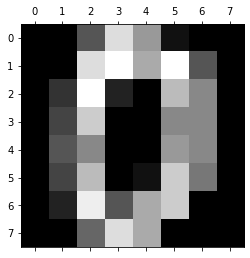

In [46]:
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[0])
plt.show()

Нормализуем данные

In [47]:
X, Y = digits.data, digits.target

In [48]:
X = (X - X.mean()) / np.max(X)

In [49]:
X.shape

(1797, 64)

In [50]:
X = np.reshape(X, (1797, 8, 8))

In [51]:
X.shape

(1797, 8, 8)

In [52]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=100, random_state = 42)

In [74]:
NNConv = Network_multiclass([ConvLayer(pad = True), LeakyRelu(alpha=0.2), 
                             ConvLayer(pad = True), LeakyRelu(alpha=0.2), 
                             ConvLayer(pad = True), LeakyRelu(alpha=0.2), 
                             Flatten(), Linear(64, 30), LeakyRelu(alpha=0.2), Linear(30, 10), Softmax()])
train_network_conv(NNConv, train_X, train_Y, lr = 0.003, criterion = 2.0, max_iter = 1500, debug = 0)

iteration 0, average_loss = 26.57371950149536
iteration 50, average_loss = 26.558252410393592
iteration 100, average_loss = 26.542555289567595
iteration 150, average_loss = 26.543157531286788
iteration 200, average_loss = 26.55095594131611
iteration 250, average_loss = 26.543310744855685
iteration 300, average_loss = 26.51920401912686
iteration 350, average_loss = 26.52878392437903
iteration 400, average_loss = 26.540667539744483
iteration 450, average_loss = 26.542445611690553
iteration 500, average_loss = 26.51630897160959
iteration 550, average_loss = 26.499348079806918
iteration 600, average_loss = 26.478885567123974
iteration 650, average_loss = 26.48736007055764
iteration 700, average_loss = 26.505161568880318
iteration 750, average_loss = 26.43121115838734
iteration 800, average_loss = 26.45625713939536
iteration 850, average_loss = 26.430863510055953
iteration 900, average_loss = 26.437184793225413
iteration 950, average_loss = 26.437452049212983
iteration 1000, average_loss = 

In [54]:
from sklearn.metrics import accuracy_score

In [55]:
Y_hat = NNConv.forward(test_X)
Y_hat = np.argmax(Y_hat, axis = 1)

In [56]:
accuracy_score(test_Y, Y_hat)

0.8

In [73]:
from sklearn.metrics import precision_score, recall_score
precision_score(test_Y, Y_hat, average = "micro")

0.94

In [58]:
recall_score(test_Y, Y_hat, average = "micro")

0.8

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
conf = confusion_matrix(test_Y, Y_hat)

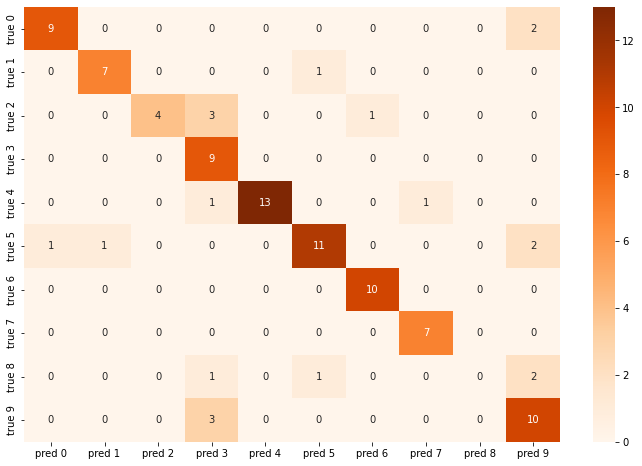

In [61]:
from string import ascii_uppercase
from pandas import DataFrame
import seaborn as sn
from sklearn.metrics import confusion_matrix

lines = ["true "+str(i) for i in range(10)]
columns = ["pred "+str(i) for i in range(10)]
conf_df = DataFrame(conf, index=lines, columns=columns)
plt.figure(figsize = (12,8))
ax = sn.heatmap(conf_df, cmap='Oranges', annot=True)

<Figure size 432x288 with 0 Axes>

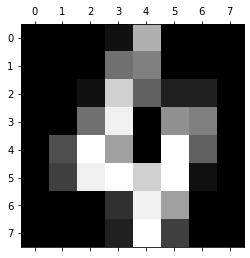

In [62]:
plt.gray()
plt.matshow(digits.images[4])
plt.show()

In [63]:
conv_img = NNConv.layers[0].forward(digits.images[4])

<Figure size 432x288 with 0 Axes>

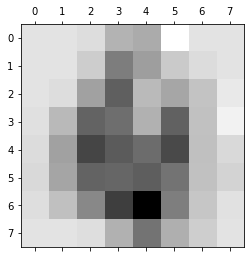

In [64]:
plt.gray()
plt.matshow(conv_img)
plt.show()

In [65]:
conv_conv_img = NNConv.layers[2].forward(conv_img)

<Figure size 432x288 with 0 Axes>

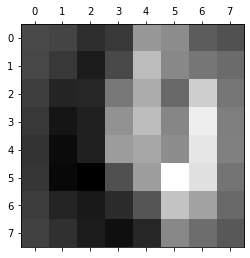

In [66]:
plt.gray()
plt.matshow(conv_conv_img)
plt.show()

BatchNorm

Nesterov
Momentum?

In [67]:
class BatchNorm:
    
    
    def __init__(self):
        self.inference = False
        self.g = 1
        self.b = 1
        self.m = 0
        self.v = 0    
        self.mu = None
        self.var = None
        self.X_ = None
        self.X_norm_ = None
        self.momentum = 0.1
        
    def forward(self, X):
        eps = 1e-10
        if not self.inference:
            self.X_ = X
            self.mu = X.mean(axis=0)
            self.var = np.power(X - self.mu, 2).mean(axis = 0)
            
            self.m = (1 - self.momentum) * self.m + self.momentum * self.mu
            self.v = (1 - self.momentum) * self.v + self.momentum * self.var

            X_norm = (X - self.mu) / np.sqrt(self.var + eps)
            self.X_norm_ = X_norm
            return X_norm * self.g + self.b
        
        else:
            return X * self.g / np.sqrt(self.v + eps) + (self.b - self.g * self.m / np.sqrt(self.v + eps))
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        eps = 1e-10
        dldX_norm = upstr_grad * self.g
        # помним, что self.var - матрица, следовательно, dldvar и dldmu - тоже матрицы
        dldvar = (dldX_norm * (self.X_ - self.mu) * (-1/2) * np.power(self.var + eps, -3/2)).sum(axis=0)
        dldmu = dldX_norm * (-1) / np.sqrt(self.var + eps).sum(axis=0) + dldvar * 1/self.X_.shape[0] * ((-2) * (self.X_ - self.mu)).sum(axis=0)
        dldX = dldX_norm * 1 / np.sqrt(self.var + eps) + dldvar * 1 / self.X_.shape[0] * 2 * (self.X_ - self.mu) + dldmu * 1 / self.X_.shape[0]
        dldg = (upstr_grad * self.X_norm_).sum(axis=0)
        dldb = upstr_grad.sum(axis=0)
        
        self.g += (-1) * lr * dldg
        self.b += (-1) * lr * dldb
        return dldX

In [68]:
NNConv_batch = Network_multiclass([ConvLayer(pad = True), BatchNorm(), LeakyRelu(alpha=0.2), 
                          ConvLayer(pad = True), BatchNorm(), LeakyRelu(alpha=0.2), 
                          ConvLayer(pad = True), BatchNorm(), LeakyRelu(alpha=0.2), 
                          Flatten(), Linear(64, 30), BatchNorm(), LeakyRelu(alpha=0.2), Linear(30, 10), Softmax()])

NNConv_batch.train_mode()
train_network_conv(NNConv_batch, train_X, train_Y, lr = 0.003, criterion = 2.0, max_iter = 1500, debug = 0)

iteration 0, average_loss = 29.54027009010315
iteration 50, average_loss = 26.051019662048077
iteration 100, average_loss = 22.517729233144074
iteration 150, average_loss = 19.888360477429412
iteration 200, average_loss = 17.768689172094813
iteration 250, average_loss = 16.31401437987647
iteration 300, average_loss = 14.675274817857774
iteration 350, average_loss = 13.51960956716445
iteration 400, average_loss = 12.766945606005878
iteration 450, average_loss = 13.222250869064315
iteration 500, average_loss = 10.351147763132177
iteration 550, average_loss = 11.618081150512555
iteration 600, average_loss = 11.229018777598203
iteration 650, average_loss = 11.33473217420609
iteration 700, average_loss = 8.901781406181602
iteration 750, average_loss = 10.239558331879282
iteration 800, average_loss = 10.490424414741895
iteration 850, average_loss = 9.85658410519324
iteration 900, average_loss = 7.445730444716678
iteration 950, average_loss = 9.13127023384528
iteration 1000, average_loss = 9.

In [69]:
NNConv_batch.inference_mode()

In [70]:
Y_hat = NNConv_batch.forward(test_X)
Y_hat = np.argmax(Y_hat, axis = 1)

In [71]:
accuracy_score(test_Y, Y_hat)

0.94

In [72]:
precision_score(test_Y, Y_hat, average = "micro")

0.94